앞서 배운 x가 1개인 선형 회귀를 단순 선형 회귀(Simple Linear Regression)이라고 한다.<br>
이번 챕터에서는 다수의 x로부터 y를 예측하는 다중 선형 회귀(Multivariable Linear Regression)에 대해서 이해한다.

## 1. 데이터에 대한 이해(Data Definition)
---
다음과 같은 훈련데이터가 있다. 3개의 퀴즈 점수로부터 최종 점수를 예측하는 모델을 만들어본다.
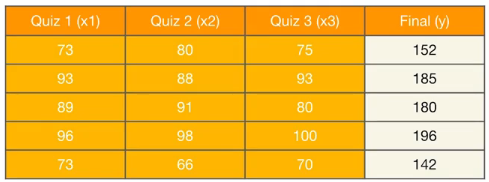<br>
독립 변수 x의 개수가 3개므로 이를 수식으로 표현하면 아래와 같다.
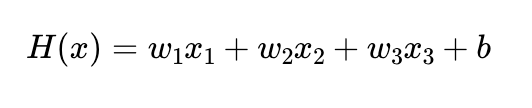

## 2. 파이토치로 구현하기
---
필요한 도구들을 import하고 랜덤 시드를 고정한다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.manual_seed(1)

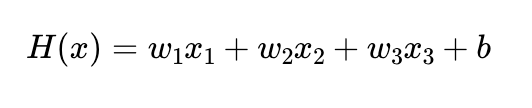

위 식을 보면 단순 선형 회귀와 다르게 x의 개수가 3개다. 그러니깐 x를 3개 선언한다.

In [3]:
x1_train = torch.FloatTensor([[73], [93], [89], [96], [73]])
x2_train = torch.FloatTensor([[80], [88], [91], [98], [66]])
x3_train = torch.FloatTensor([[75], [93], [90], [100], [70]])
y_train = torch.FloatTensor([[152], [185], [180], [196], [142]])

이제 가중치 w와 편향 b를 선언한다. 가중치 w로 3개 선언해야한다.

In [4]:
w1 = torch.zeros(1, requires_grad=True)
w2 = torch.zeros(1, requires_grad=True)
w3 = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

이제 가설, 비용 함수, 옵티마이저를 선언한 후에 경사 하강법을 1,000회 반복한다.

In [6]:
# optimizer 설정
optimizer = optim.SGD([w1, w2, w3, b], lr=1e-5)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):
    
    # H(x) 계산
    hypothesis = x1_train * w1 + x2_train * w2 + x3_train * w3 + b
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 100번마다 로그 출력
    if epoch % 100 ==0:
        print('Epoch {:4d}/{} w1: {:.3f} w2: {:.3f} w3: {:.3f} b: {:.3f} Cost: {:.6f}'.format(
            epoch, nb_epochs, w1.item(), w2.item(), w3.item(), b.item(), cost.item()
        ))

Epoch    0/1000 w1: 0.294 w2: 0.294 w3: 0.297 b: 0.003 Cost: 29661.800781
Epoch  100/1000 w1: 0.674 w2: 0.661 w3: 0.676 b: 0.008 Cost: 1.563634
Epoch  200/1000 w1: 0.679 w2: 0.655 w3: 0.677 b: 0.008 Cost: 1.497607
Epoch  300/1000 w1: 0.684 w2: 0.649 w3: 0.677 b: 0.008 Cost: 1.435026
Epoch  400/1000 w1: 0.689 w2: 0.643 w3: 0.678 b: 0.008 Cost: 1.375730
Epoch  500/1000 w1: 0.694 w2: 0.638 w3: 0.678 b: 0.009 Cost: 1.319511
Epoch  600/1000 w1: 0.699 w2: 0.633 w3: 0.679 b: 0.009 Cost: 1.266222
Epoch  700/1000 w1: 0.704 w2: 0.627 w3: 0.679 b: 0.009 Cost: 1.215696
Epoch  800/1000 w1: 0.709 w2: 0.622 w3: 0.679 b: 0.009 Cost: 1.167818
Epoch  900/1000 w1: 0.713 w2: 0.617 w3: 0.680 b: 0.009 Cost: 1.122429
Epoch 1000/1000 w1: 0.718 w2: 0.613 w3: 0.680 b: 0.009 Cost: 1.079378


## 3. 벡터와 행렬 연산으로 바꾸기
---
위의 코드를 개선할 수 있는 부분이 있다. 이번에는 x의 개수가 3개였으니깐 x1_train, x2_train, x3_train와 w1, w2, w3을 일일이 선언했다. 만약 x의 개수가 1,000개 일 경우 변수 선언만 총 2,000번을 해야한다. 이는 굉장히 비효율적이다. <br><br>
이를 해결하기 위해 행렬 곱셈 연산(또는 벡터의 내적)을 사용한다.
- **행렬의 곱셈 과정에서 이루어지는 벡터 연산을 벡터의 내적(Dot Product)이라고 한다.**
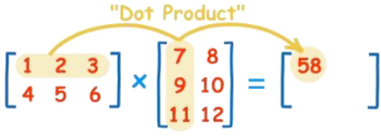
위의 그림은 행렬 곱셈 연산 과정에서 벡터의 내적으로 1 x 7 + 2 x 9 + 3 x 11 = 58이 되는 과정을 보여준다. <br><br>
이와 같이 벡터와 행렬 연산으로 가설을 표현해준다.<br><br>
### 1. 벡터 연산으로 이해하기
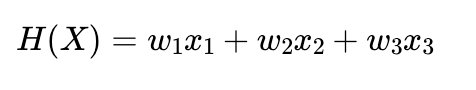
위 식은 아래와 같이 두 벡터의 내적으로 표현할 수 있다.
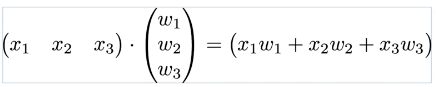
두 벡터를 각각 X와 W로 표현한다면, 가설은 다음과 같다. <br>
H(X) = XW <br>
x의 개수가 3개였음에도 이제는 X와 W라는 두 개의 변수로 표현된 것을 볼 수 있다.<br><br>
### 2. 행렬 연산으로 이해하기
훈련 데이터를 살펴보고, 벡터와 행렬 연산을 통해 가설 H(X)를 표현해본다.
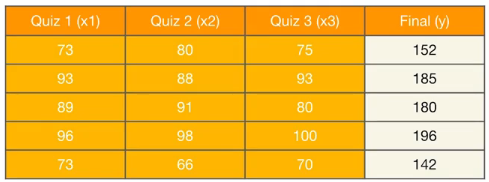
전체 훈련 데이터의 개수를 셀 수 있는 1개의 단위를 샘플(sample)이라고 한다. 현재 샘플의 수는 총 5개다.<br>
각 샘플에서 y를 결정하게 하는 각각의 독립 변수 x를 특성(feature)이라고 한다. 현재 특성은 3개다.<br><br>
이는 독립 변수 x들의 수가 (샘플의 수 x 특성의 수) = 15개임을 의미한다. 독립 변수 x들을 (샘플의 수 x 특성의 수)의 크기를 가지는 하나의 행렬로 표현해본다. 그리고 이 행렬을 X라고 한다.
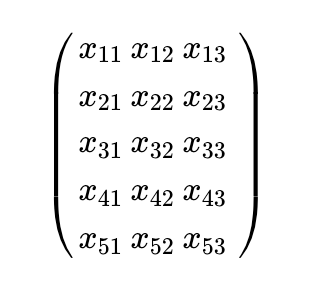
그리고 여기에 가중치 w1, w2, w3을 원소로 하는 벡터를 W라 하고 곱해본다.
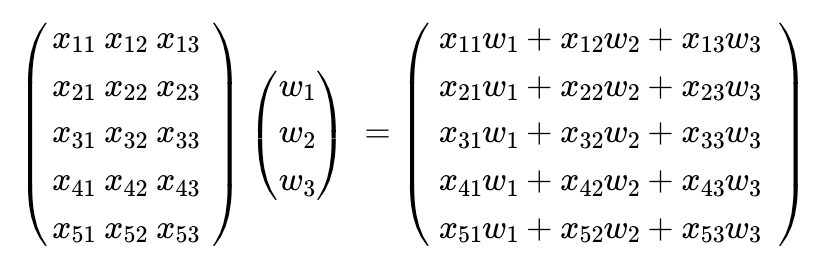
위의 식은 결과적으로 H(X) = XW와 같고 <br>
이 가설에 각 샘플에 더해지는 편향 b를 추가해본다. 샘플 수만큼의 차원을 가지는 편향 벡터 B를 만들어 더한다.
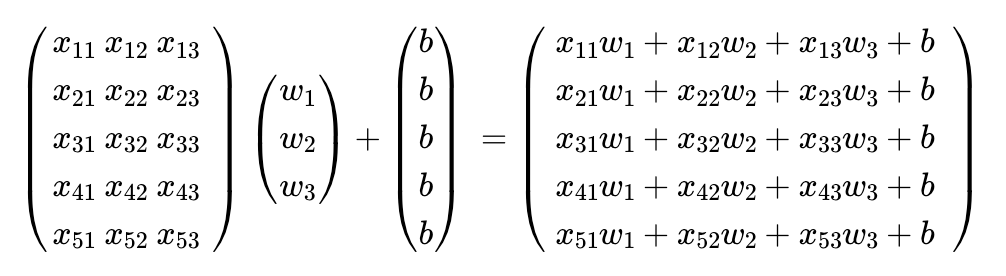
위의 식은 결과적으로 H(X) = XW + B와 같다. <br>
결과적으로 전체 훈련 데이터의 가설 연산을 3개의 변수만으로 표현했다. 이와 같이 벡터와 행렬 연산은 식을 간단하게 해줄 뿐만 아니라 다수의 샘플의 병렬 연산이므로 속도의 이점을 가진다.

## 4. 행렬 연산을 고려하여 파이토치로 구현하기
---
이번에는 행렬 연산을 고려하여 파이토치로 재구현해본다. <br>

In [7]:
x_train = torch.FloatTensor([[73, 80, 75],
                             [93, 88, 93],
                             [89, 91, 80],
                             [96, 98, 100],
                             [73, 66, 70]])
y_train = torch.FloatTensor([[152], [185], [180], [196], [142]])

In [8]:
print(x_train.shape)
print(y_train.shape)

torch.Size([5, 3])
torch.Size([5, 1])


In [10]:
# 가중치와 편향 선언
W = torch.zeros((3, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

여기서 주목할 점은 가중치 W의 크기가 (3 x 1) 벡터라는 점이다. 행렬의 곱셈이 성립되려면 좌측에 있는 행렬의 열의 크기와 우측에 있는 행렬의 크기가 일치해야한다. 현재 X_train의 행렬의 크기는 (5 x 3)이며, W 벡터의 크기는 (3 x 1)이므로 두 행렬과 벡터는 행렬곱이 가능하다. 행렬곱으로 가설을 선언하면 아래와 같다.

In [11]:
hypothesis = x_train.matmul(W) + b

가설을 행렬곱으로 간단히 정의하였다. 이는 앞서 x_train과 w의 곱셈이 이루어지는 각 항을 전부 기재하여 가설을 선언했던 것과 대비된다. 이 경우, 사용자가 독립 변수 x의 수를 후에 추가적으로 늘리거나 줄이더라도 위의 가설 선언 코드를 수정할 필요가 없다. 이제 해야할 일은 비용 함수와 옵티마이저를 정의하고, 정해진 에포크만큼 훈련을 진행하는 일이다.

In [14]:
x_train = torch.FloatTensor([[73, 80, 75],
                            [93, 88, 93],
                            [89, 91, 80],
                            [96, 98, 100],
                            [73, 66, 70]])
y_train = torch.FloatTensor([[152], [185], [180], [196], [142]])

# 모델 초기화
W = torch.zeros((3, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# optimizer 설정
optimizer = optim.SGD([W, b], lr=1e-5)

nb_epochs = 20

for epoch in range(nb_epochs + 1):
    
    # H(X) 계산
    # 편향 b는 브로드캐스팅되어 각 샘플에 더해진다.
    hypothesis = x_train.matmul(W) + b
    
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)
    
    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/20 hypothesis: tensor([0., 0., 0., 0., 0.]) Cost: 29661.800781
Epoch    1/20 hypothesis: tensor([66.7178, 80.1701, 76.1025, 86.0194, 61.1565]) Cost: 9537.694336
Epoch    2/20 hypothesis: tensor([104.5421, 125.6208, 119.2478, 134.7862,  95.8280]) Cost: 3069.590088
Epoch    3/20 hypothesis: tensor([125.9858, 151.3882, 143.7087, 162.4333, 115.4844]) Cost: 990.670898
Epoch    4/20 hypothesis: tensor([138.1429, 165.9963, 157.5768, 178.1071, 126.6283]) Cost: 322.482086
Epoch    5/20 hypothesis: tensor([145.0350, 174.2780, 165.4395, 186.9928, 132.9461]) Cost: 107.717064
Epoch    6/20 hypothesis: tensor([148.9423, 178.9730, 169.8976, 192.0301, 136.5279]) Cost: 38.687496
Epoch    7/20 hypothesis: tensor([151.1574, 181.6346, 172.4254, 194.8856, 138.5585]) Cost: 16.499043
Epoch    8/20 hypothesis: tensor([152.4131, 183.1435, 173.8590, 196.5043, 139.7097]) Cost: 9.365656
Epoch    9/20 hypothesis: tensor([153.1250, 183.9988, 174.6723, 197.4217, 140.3625]) Cost: 7.071114
Epoch   10/20 hyp